# **Training a CNN to classify the CIFAR-10 dataset**
Adapted from pytorch.org/tutorials : "Training a Classifier"


In [24]:
# libraries we need
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

In [25]:
# the whole point of pytorch is to be able to easily train models on GPU's and TPU's
# if you have a dedicated GPU, you can download CUDA from Nvidia toolkits
# this snippet of code will check if you have cuda installed, and will set the 'device' accordingly
# for now, it should probably return "Running on CPU"

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU
Tesla T4


## Data processing

In [26]:
# download the CIFAR 10 training and testing data sets from torchvision.datasets

train_dataset = torchvision.datasets.CIFAR10(root='./cifar10', transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, transform=torchvision.transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Create training and testing loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle=True)

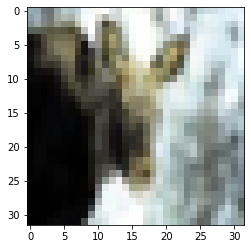

In [28]:
# visualizing a sample from train loader

train_iter = iter(train_loader)

batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
plt.imshow(image.permute(1,2,0))
plt.show()

## Building the model

Remember, that CNN's have a typical architecture that involve CONV -> Maxpool -> .... -> FC -> ... Output 

https://pytorch.org/docs/stable/index.html

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.neural_net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size = 3, stride = 1, padding = 1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Flatten(),
            nn.Linear(1024*4*4, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 512), 
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        return self.neural_net(x)

In [30]:
model = CNN()

model.to('cuda:0') # specify that this model will be stored on the device you chose earlier (GPU or CPU)

CNN(
  (neural_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

In [31]:
# Loss Function
criterion = nn.CrossEntropyLoss()

In [32]:
# Adam Optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay=1e-5) 

## Training

In [33]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    for i, batch in tqdm(enumerate(train_loader), leave=False):
        batch_inputs, batch_labels = batch  # get our train inputs and labels
        batch_inputs = batch_inputs.to(device)  # put our data on GPU or CPU (device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_inputs)  # pass inputs through model to get predictions (PyTorch is tracking this!)
        loss = criterion(predictions, batch_labels)  # compute loss (PyTorch is still tracking this!)
        loss.backward()  # backpropagation through PyTorch's computation graph created from the above two lines
                         # gradients stored in .grad parameter of all model parameters
        optimizer.step()  # use the .grad gradients in model parameters to perform gradient-descent based optimization (Adam)
        optimizer.zero_grad()  # zero out the gradients---we have finished SGD and don't need them anymore!

    print('End of epoch loss:', round(loss.item(), 3))

## Testing

In [34]:
def test(model, test_loader, device):
    # we've manually specified the classes - these are from the cifar-10 dataset
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # what is the first thing to do before testing?
    model.eval()  # tell PyTorch: stop tracking gradients! We don't need it here
    correct = 0  # for accumulating number of correct guesses
    for i, batch in enumerate(test_loader):
        batch_inputs, batch_labels = batch
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_inputs)
        predictions = predictions.argmax(axis=1)  # get index of maximum output channel, i.e., the prediction
        correct += (predictions == batch_labels).sum().item()  # count number of correct guesses
        
    print('End of epoch accuracy:', 100*correct/len(test_dataset), '%')  # accuracy is (# correct) / (# total)
    

    # visualizing the current model's performance - no changes required
    for i in range(3):
        print('Guess:', classes[predictions[i]], '| Label:', classes[batch_labels[i]])
        plt.imshow(batch_inputs[i].cpu().permute(1,2,0))
        plt.show()

# Running the train-test loop

Epoch:  1


End of epoch loss: 0.04
End of epoch accuracy: 78.43 %
Guess: ship | Label: ship


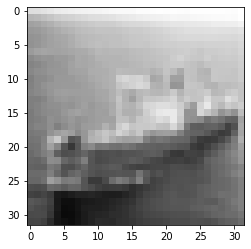

Guess: cat | Label: cat


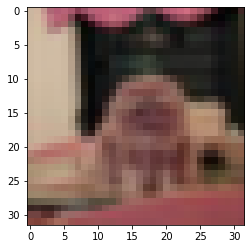

Guess: car | Label: car


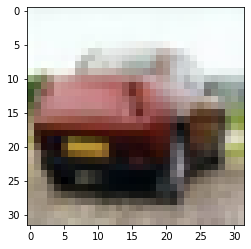

Epoch:  2


End of epoch loss: 0.028
End of epoch accuracy: 79.04 %
Guess: bird | Label: deer


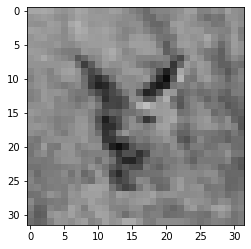

Guess: cat | Label: horse


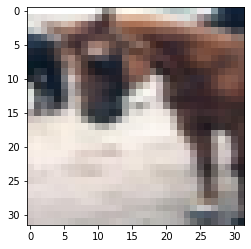

Guess: cat | Label: dog


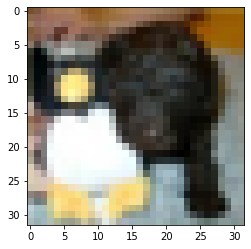

Epoch:  3


End of epoch loss: 0.04
End of epoch accuracy: 78.65 %
Guess: ship | Label: ship


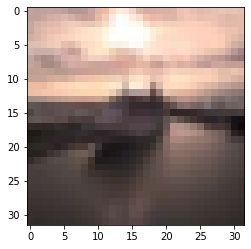

Guess: horse | Label: dog


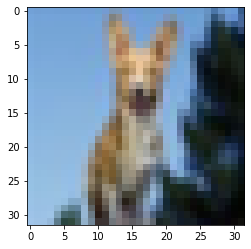

Guess: car | Label: car


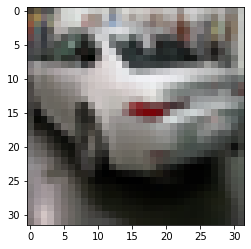

Epoch:  4


End of epoch loss: 0.062
End of epoch accuracy: 79.83 %
Guess: frog | Label: frog


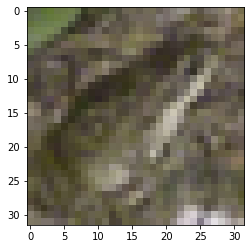

Guess: truck | Label: truck


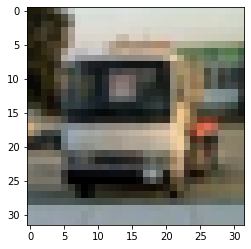

Guess: horse | Label: horse


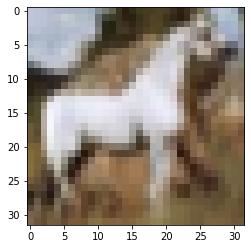

Epoch:  5


End of epoch loss: 0.042
End of epoch accuracy: 79.34 %
Guess: deer | Label: deer


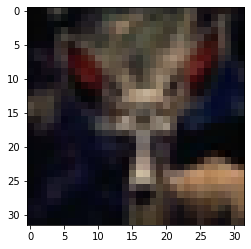

Guess: ship | Label: ship


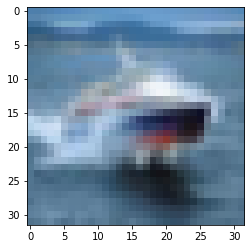

Guess: truck | Label: truck


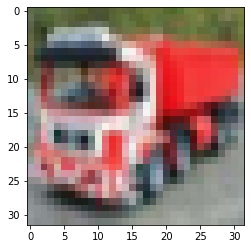

Epoch:  6


End of epoch loss: 0.009
End of epoch accuracy: 78.97 %
Guess: ship | Label: ship


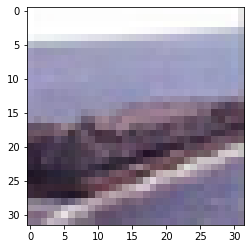

Guess: cat | Label: dog


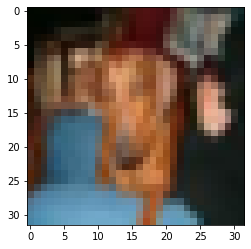

Guess: truck | Label: truck


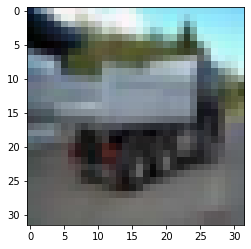

Epoch:  7


End of epoch loss: 0.015
End of epoch accuracy: 79.57 %
Guess: truck | Label: truck


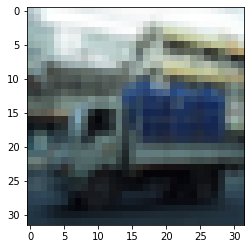

Guess: truck | Label: truck


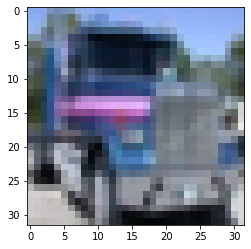

Guess: frog | Label: dog


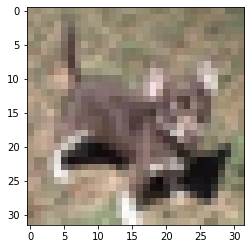

Epoch:  8


End of epoch loss: 0.068
End of epoch accuracy: 78.89 %
Guess: dog | Label: dog


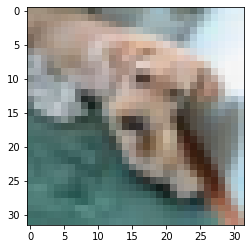

Guess: bird | Label: bird


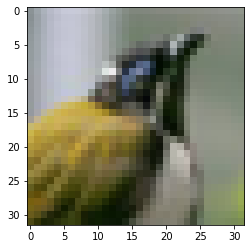

Guess: dog | Label: horse


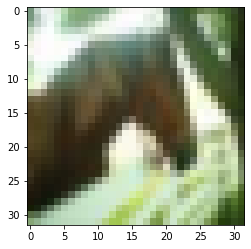

Epoch:  9


End of epoch loss: 0.01
End of epoch accuracy: 79.03 %
Guess: dog | Label: horse


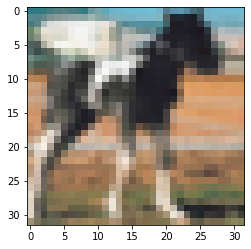

Guess: dog | Label: dog


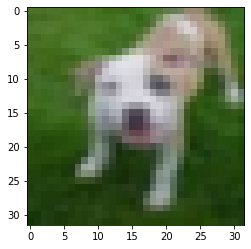

Guess: horse | Label: horse


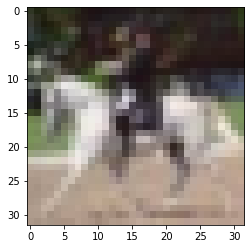

Epoch:  10


End of epoch loss: 0.063
End of epoch accuracy: 79.05 %
Guess: car | Label: car


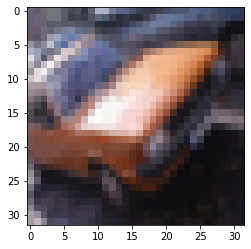

Guess: frog | Label: bird


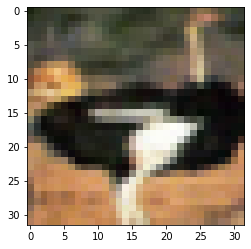

Guess: truck | Label: truck


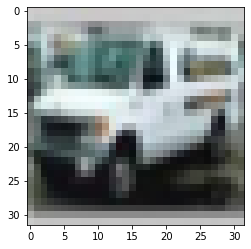

In [40]:
# run a loop which calls the training and testing functions
# you just created
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch + 1)
    train_one_epoch(model, train_loader, optimizer, criterion, device)
    test(model, test_loader, device)

## Saving the weights

In [41]:
torch.save(model.state_dict(), './model.pt')



## Loading the weights

In [42]:
# Run this cell and train again
newModel = CNN()
newModel.load_state_dict(torch.load('./model.pt'))



<All keys matched successfully>